### Step 1: Load the Libraies and Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from numpy.linalg import lstsq
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import LSTM, Dense, Dropout, GRU, Conv1D, SimpleRNN
from keras.callbacks import EarlyStopping 

2024-05-08 13:49:41.935159: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# extracting the data 
data = pd.read_csv("TexasTurbine.csv")
data.head()

,Time stamp,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C)
0,"Jan 1, 12:00 am",1766.64,9.926,128,1.000480,18.263
1,"Jan 1, 01:00 am",1433.83,9.273,135,0.999790,18.363
2,"Jan 1, 02:00 am",1167.23,8.660,142,0.999592,18.663
3,"Jan 1, 03:00 am",1524.59,9.461,148,0.998309,18.763
4,"Jan 1, 04:00 am",1384.28,9.184,150,0.998507,18.963


## Section 1: Data Description

In [3]:
# data decsription (we can see that the data is not normalized) 
data.describe()

,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air temperature | ('C)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,964.467934,7.376120,146.616210,0.992368,22.147298
std,878.558112,3.138291,84.678754,0.005332,4.855232
min,0.000000,0.119000,0.000000,0.974514,3.263000
25%,215.951500,5.121000,99.000000,0.988925,19.463000
50%,693.968500,7.340500,135.000000,0.991495,22.763000
75%,1562.287500,9.599000,169.000000,0.995045,26.063000
max,3004.010000,19.743000,360.000000,1.014510,32.963000


In [4]:
# data information (Data types, missing values, etc.)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Time stamp                     8760 non-null   object 
 1   System power generated | (kW)  8760 non-null   float64
 2   Wind speed | (m/s)             8760 non-null   float64
 3   Wind direction | (deg)         8760 non-null   int64  
 4   Pressure | (atm)               8760 non-null   float64
 5   Air temperature | ('C)         8760 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 410.8+ KB


In [5]:
data.isnull().sum()

Time stamp                       0
System power generated | (kW)    0
Wind speed | (m/s)               0
Wind direction | (deg)           0
Pressure | (atm)                 0
Air temperature | ('C)           0
dtype: int64

## Section 2: Feature Selection (Techniques)

/var/folders/_r/bqfz50_j6bzdgq_8h_x74tnc0000gn/T/ipykernel_10337/2408363256.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=2)


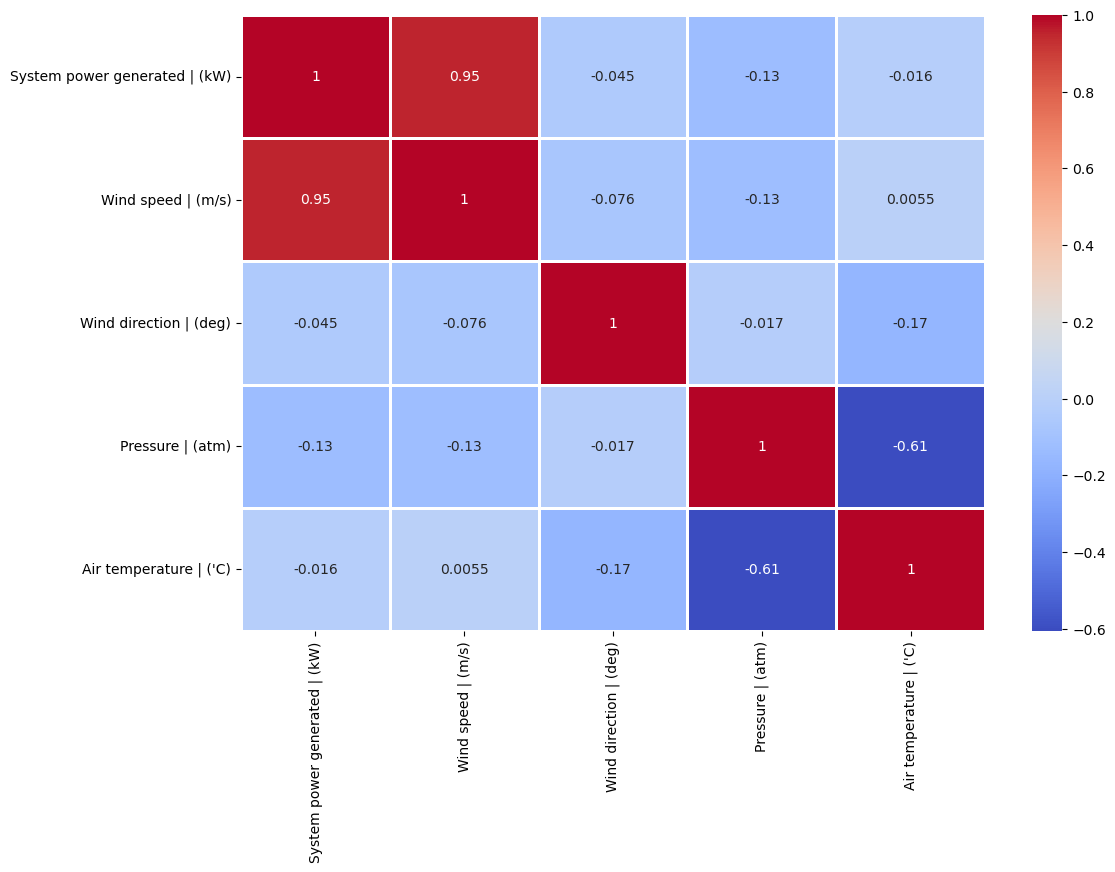

In [3]:
# using the seaborn heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=2)
plt.show()

In [3]:
# rename the air temperature column Air temperature | ('C) to Air_temperature (C)
data = data.rename(columns={"Air temperature | ('C)": "Air_temperature (C)"})

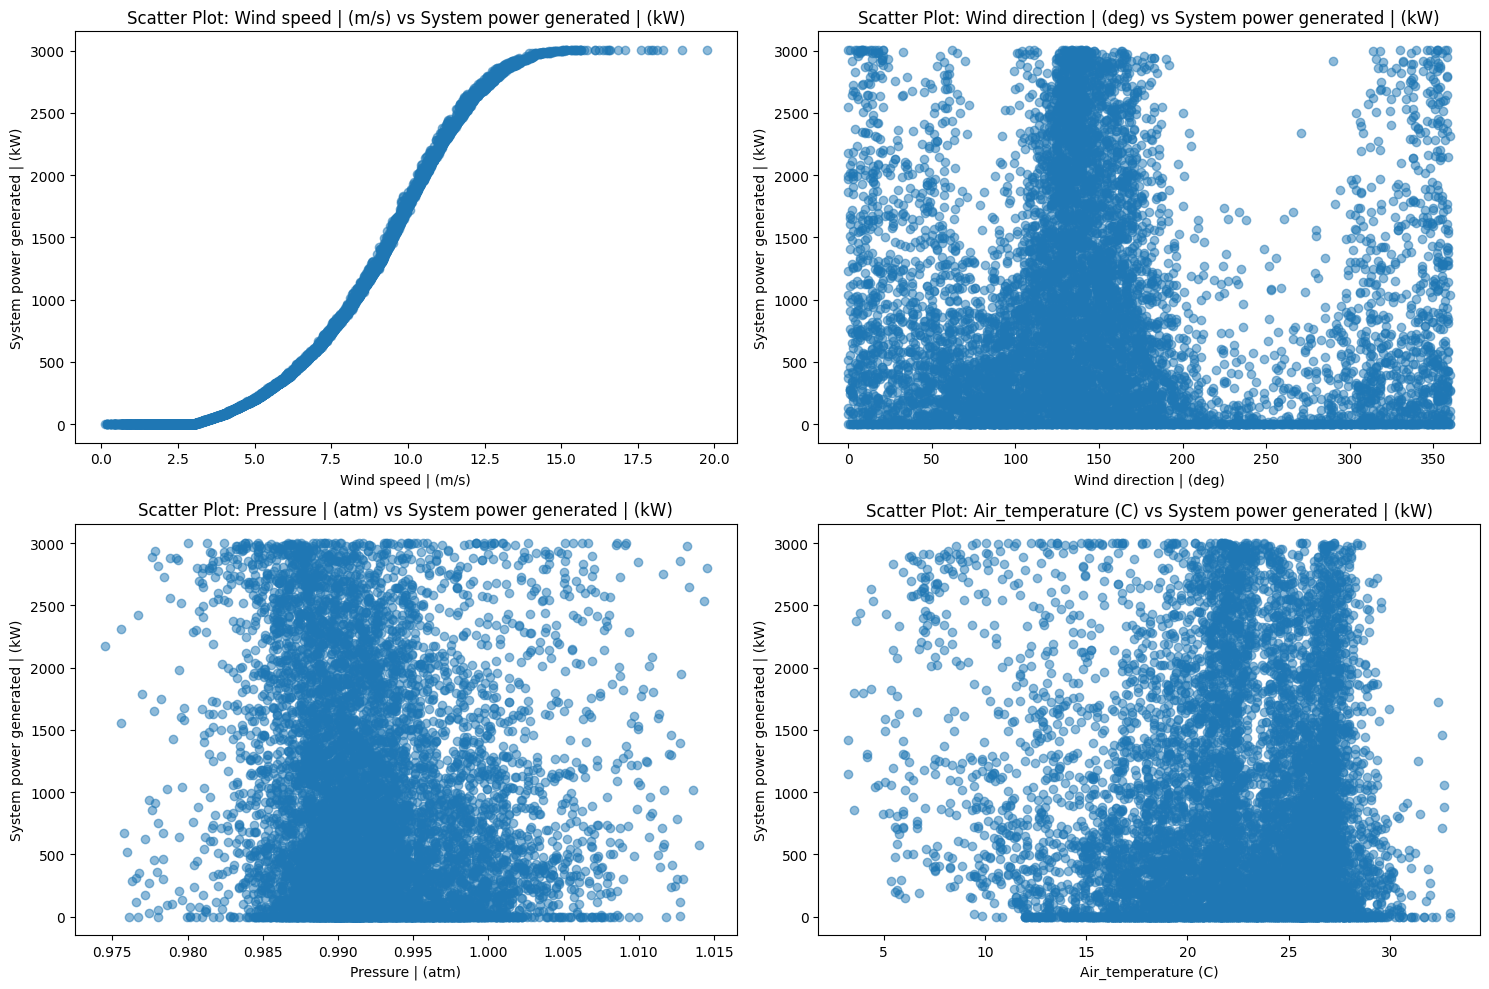

In [4]:
target = 'System power generated | (kW)'
features = ['Wind speed | (m/s)', 'Wind direction | (deg)', 'Pressure | (atm)', 'Air_temperature (C)']

# Create scatter plots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)  
    plt.scatter(data[feature], data[target], alpha=0.5)
    plt.title(f'Scatter Plot: {feature} vs {target}')
    plt.xlabel(feature)
    plt.ylabel(target)

plt.tight_layout()
plt.show()

Method for Forward and Backward Feature Selection

For Forward Feature Selection:

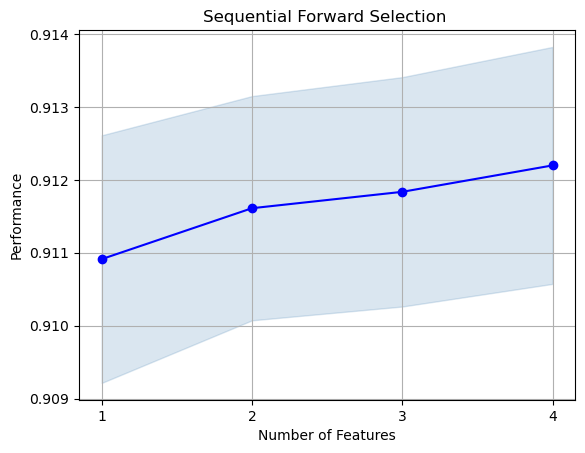

In [4]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = data.drop(['System power generated | (kW)', 'Time stamp'], axis=1)
y = data['System power generated | (kW)']

# normalize the data
scaler =MinMaxScaler()
X = scaler.fit_transform(X)
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize linear regression model
lr = LinearRegression()

# Forward feature selection
sfs_forward = SFS(lr,
           k_features='best',
           forward=True,
           floating=False,
           scoring='r2',
           cv=5)

sfs_forward = sfs_forward.fit(X_train, y_train)

metric_dict = sfs_forward.get_metric_dict(confidence_interval=0.95)
fig1 = plot_sfs(metric_dict, kind='std_err')
plt.title('Sequential Forward Selection ')
plt.grid()
plt.show()

For Backward Feature Selection:

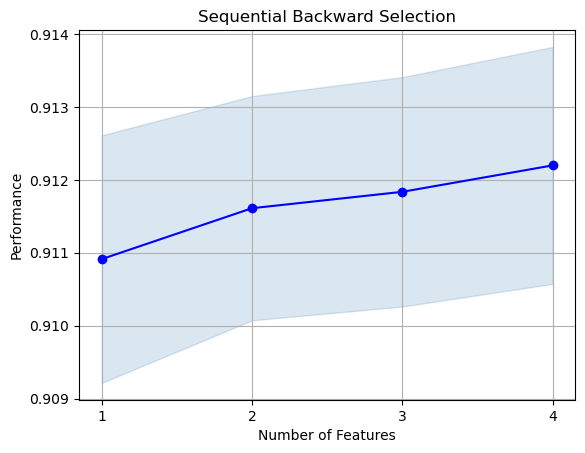

In [5]:
# Backward feature selection
sfs_backward = SFS(lr,
           k_features='best',
           forward=False,
           floating=False,
           scoring='r2',
           cv=5)

sfs_backward = sfs_backward.fit(X_train, y_train)

metric_dict_backward = sfs_backward.get_metric_dict(confidence_interval=0.95)
fig1 = plot_sfs(metric_dict_backward, kind='std_err')
plt.title('Sequential Backward Selection')
plt.grid()
plt.show()

 ## Section 3: Data Visualization

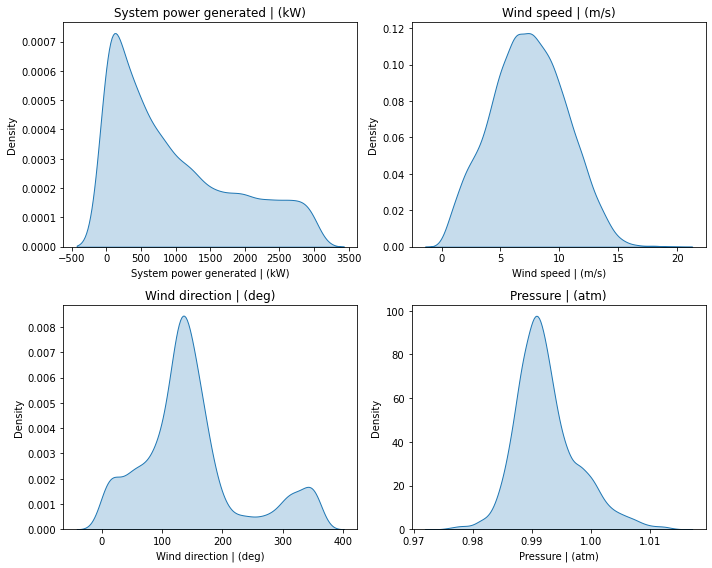

In [19]:
# plot the kde of the data
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(data.iloc[:,i+1], shade=True)
    plt.title(data.columns[i+1])
plt.tight_layout()
plt.show()

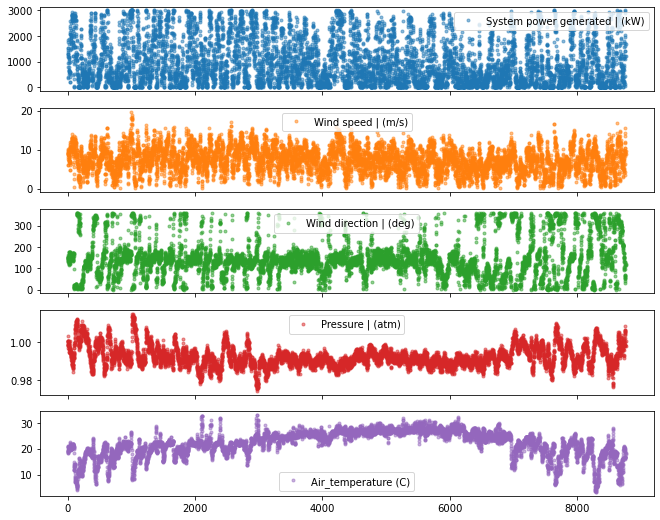

In [20]:
#plotting each data 'System power generated | (kW)', 'Wind speed | (m/s)', 'Wind direction | (deg)', 'Pressure | (atm)', 'Air temperature | ('C)'
cols = ['System power generated | (kW)', 'Wind speed | (m/s)', 'Wind direction | (deg)', 'Pressure | (atm)', 'Air_temperature (C)'] 
axes = data[cols].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

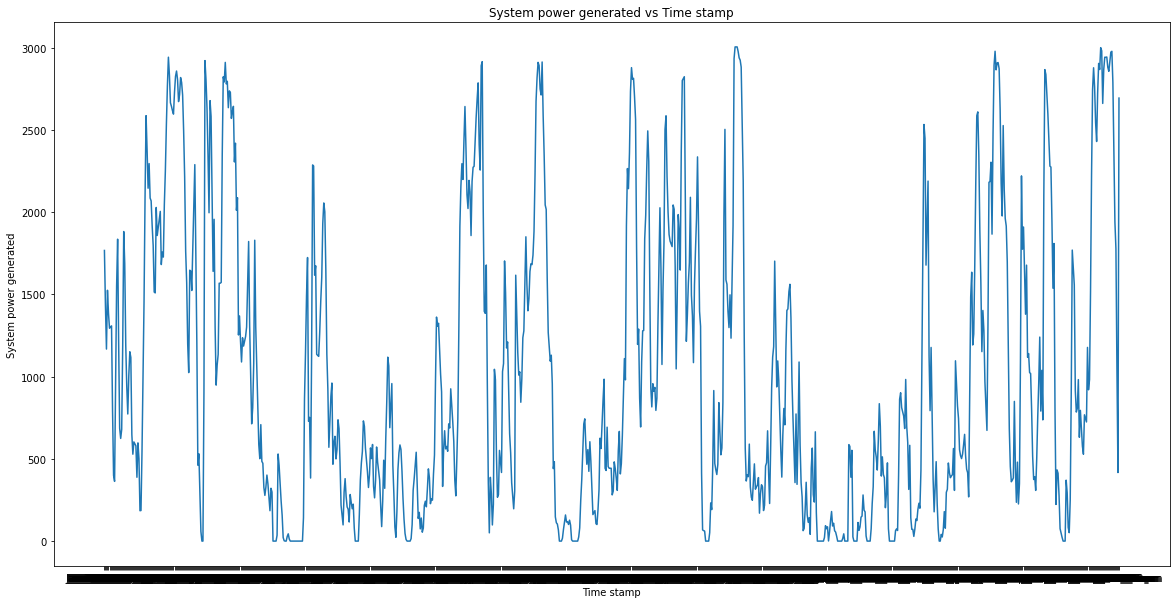

In [21]:
# line gaph of the time stamp and System power generated for the first 1000 data
plt.figure(figsize=(20, 10))
plt.plot(data['Time stamp'][:1000], data['System power generated | (kW)'][:1000])
plt.title('System power generated vs Time stamp')
plt.xlabel('Time stamp')
plt.ylabel('System power generated')
plt.show()

## Section 4: Preprocessing Data (Selecting the target, features, scaling, splitting)

In [22]:
data = data.set_index(data["Time stamp"])
data.head()

,Time stamp,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air_temperature (C)
Time stamp,,,,,,
"Jan 1, 12:00 am","Jan 1, 12:00 am",1766.64,9.926,128,1.000480,18.263
"Jan 1, 01:00 am","Jan 1, 01:00 am",1433.83,9.273,135,0.999790,18.363
"Jan 1, 02:00 am","Jan 1, 02:00 am",1167.23,8.660,142,0.999592,18.663
"Jan 1, 03:00 am","Jan 1, 03:00 am",1524.59,9.461,148,0.998309,18.763
"Jan 1, 04:00 am","Jan 1, 04:00 am",1384.28,9.184,150,0.998507,18.963


In [23]:
# create a new dataframe from the prevous data
data_new = data.copy()
data_new = data_new.drop(columns=['Time stamp'])
data_new.head()

,System power generated | (kW),Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air_temperature (C)
Time stamp,,,,,
"Jan 1, 12:00 am",1766.64,9.926,128,1.000480,18.263
"Jan 1, 01:00 am",1433.83,9.273,135,0.999790,18.363
"Jan 1, 02:00 am",1167.23,8.660,142,0.999592,18.663
"Jan 1, 03:00 am",1524.59,9.461,148,0.998309,18.763
"Jan 1, 04:00 am",1384.28,9.184,150,0.998507,18.963


((7008, 5), (1752, 5))

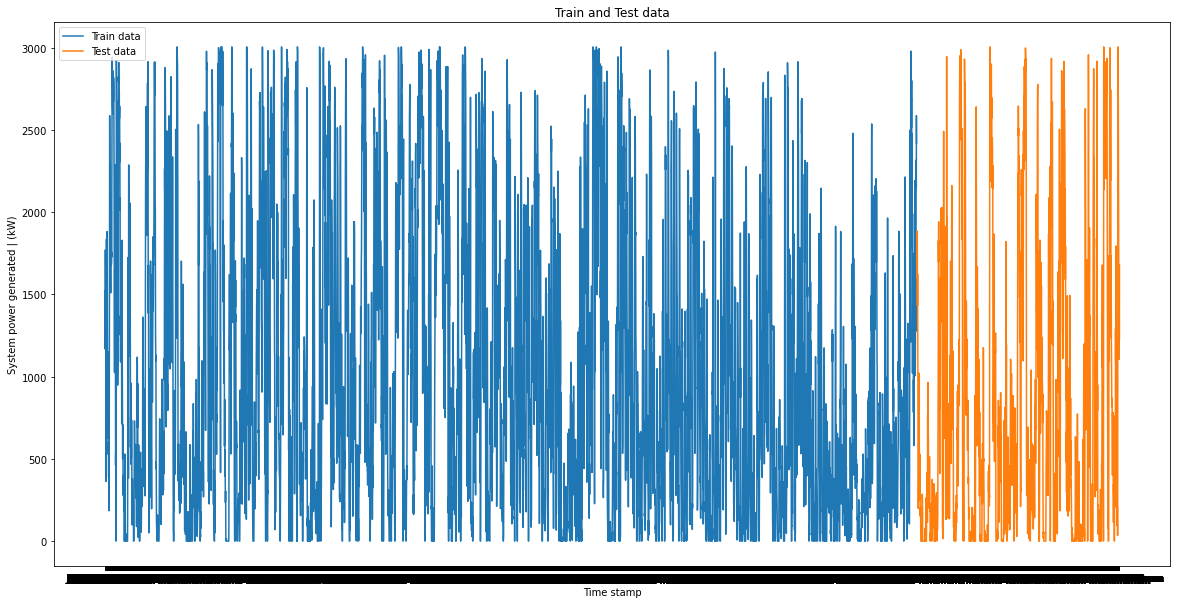

In [24]:
# split the data into training and testing data
train_size = int(len(data_new) * 0.80)
train_data, test_data = data_new.iloc[:train_size], data_new.iloc[train_size:]

#plot the train and test data
plt.figure(figsize=(20, 10))
plt.plot(train_data.index, train_data['System power generated | (kW)'], label='Train data')
plt.plot(test_data.index, test_data['System power generated | (kW)'], label='Test data')
plt.title('Train and Test data')
plt.xlabel('Time stamp')
plt.ylabel('System power generated | (kW)')
plt.legend()

# shape of the train and test data
train_data.shape, test_data.shape


In [25]:
# split the data into features and target variable
# ['System power generated | (kW)', 'Pressure | (atm)']
X_train = train_data.drop('System power generated | (kW)', axis=1)
y_train = train_data.loc[:, ['System power generated | (kW)']]
X_test = test_data.drop('System power generated | (kW)', axis=1)
y_test = test_data.loc[:,['System power generated | (kW)']]

# shape of the features and target variable
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7008, 4), (7008, 1), (1752, 4), (1752, 1))

In [26]:
X_train.head()

,Wind speed | (m/s),Wind direction | (deg),Pressure | (atm),Air_temperature (C)
Time stamp,,,,
"Jan 1, 12:00 am",9.926,128,1.000480,18.263
"Jan 1, 01:00 am",9.273,135,0.999790,18.363
"Jan 1, 02:00 am",8.660,142,0.999592,18.663
"Jan 1, 03:00 am",9.461,148,0.998309,18.763
"Jan 1, 04:00 am",9.184,150,0.998507,18.963


In [30]:
# Different scaler for input and output
scaler_x= MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
X_train_scaled = input_scaler.transform(X_train)
y_train_scaled = output_scaler.transform(y_train)

# Transform the test data
X_test_scaled = input_scaler.transform(X_test)
y_test_scaled = output_scaler.transform(y_test)

In [97]:
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 30
X_train, y_train = create_dataset(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test, y_test = create_dataset(X_test_scaled, y_test_scaled, TIME_STEPS)
# Print the shape of the sequences
print(f"X_seq train shape: {X_train.shape} | y_seq train shape : {y_train.shape}")
print(f"X_seq test shape: {X_test.shape} | y_seq test shape  : {y_test.shape}")

X_seq train shape: (6978, 30, 4) | y_seq train shape : (6978, 1)
X_seq test shape: (1722, 30, 4) | y_seq test shape  : (1722, 1)


### Step 3: Building the models and Training them

## Section 1: building the model

In [98]:
def create_model(units, layer_type):
    model = Sequential()
    
    model.add(layer_type(units=units, dropout=0.05, return_sequences=True,
                         input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    
    model.add(layer_type(units=units, dropout=0.2))
    
    model.add(Dense(units=1))
    
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer)
    return model

def create_cnn(layer_type):
    model = Sequential()
    
    model.add(layer_type(filters=64, kernel_size=3, 
                         input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    
    model.add(layer_type(filters=64, kernel_size=3))
    
    model.add(Dense(units=1))
    
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer)
    return model

# models
model_gru = create_model(32, GRU)
model_lstm = create_model(32, LSTM)
model_conv1d = create_cnn(Conv1D)
model_rnn = create_model(32, SimpleRNN)

/home/abdulrahman.almansoo/.conda/envs/bigdataproject/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/abdulrahman.almansoo/.conda/envs/bigdataproject/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [99]:
# Fit models
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7)

    # shuffle = False because the order of the data matters
    history = model.fit(X_train, y_train, epochs = 30, validation_split = 0.2,
                    batch_size = 64, shuffle = False, callbacks = [early_stop])
    return history

## Section 2: Training the models

In [100]:
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)
history_conv1d = fit_model(model_conv1d)
history_rnn = fit_model(model_rnn)

Epoch 1/30


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1226 - val_loss: 0.0449
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0741 - val_loss: 0.0418
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0687 - val_loss: 0.0385
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0615 - val_loss: 0.0341
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0558 - val_loss: 0.0275
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0467 - val_loss: 0.0233
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0423 - val_loss: 0.0215
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0373 - val_loss: 0.0197
Epoch 9/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0343 - val_loss: 0.0183
Epoch 10/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0315 - val_loss: 0.0181
Epoch 11/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0321 - val_loss: 0.0161
Epoch 12/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0284 - val_l

## Section 3: Viuslization of train and validation loss

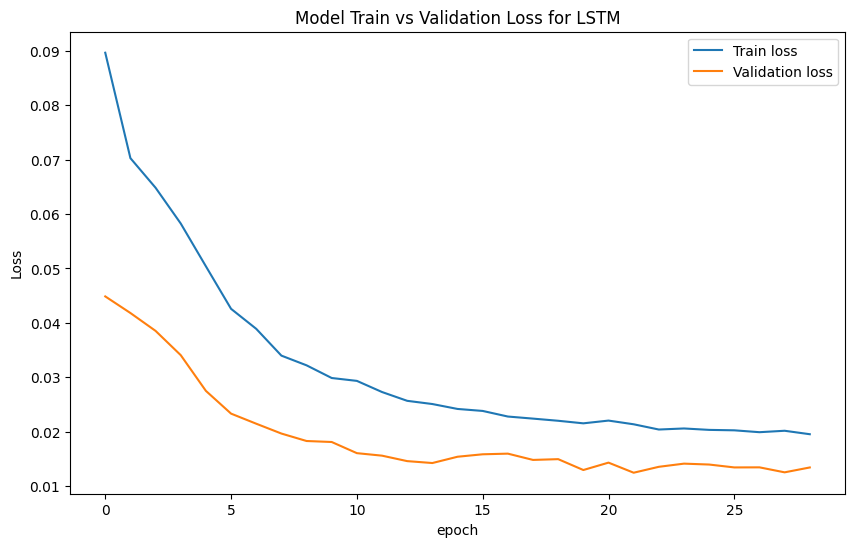

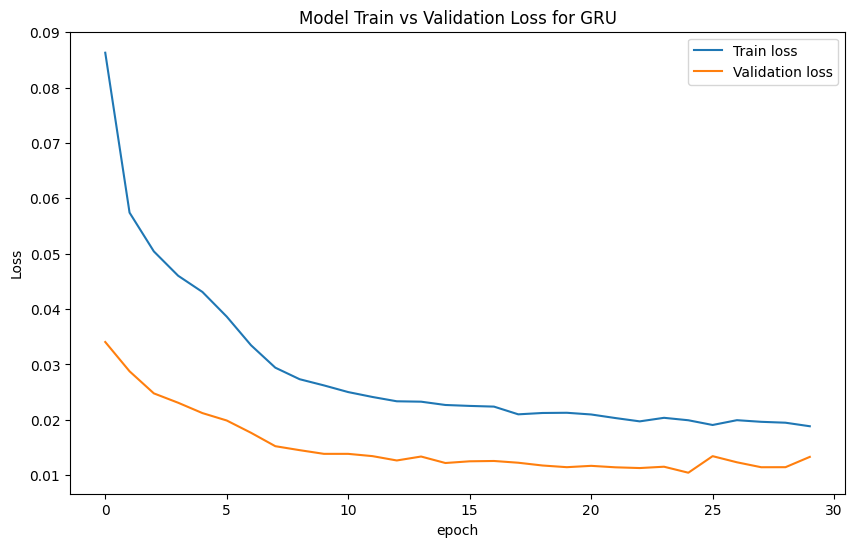

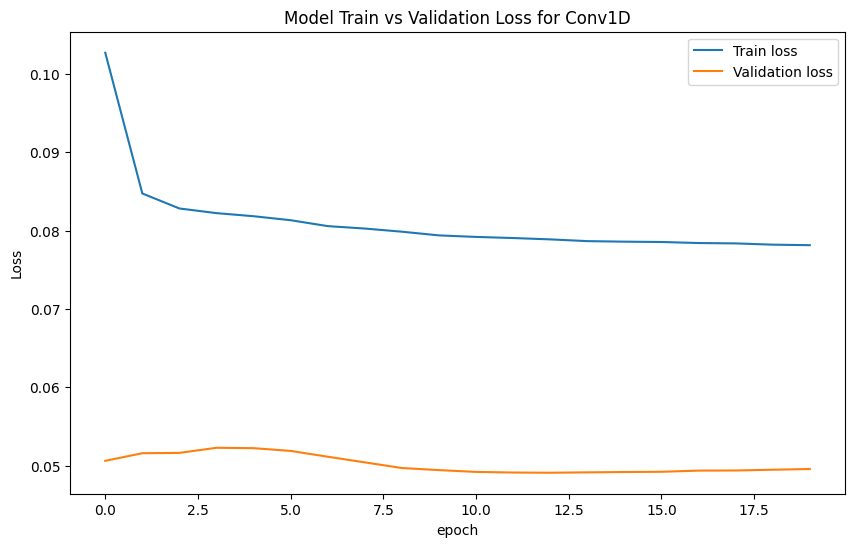

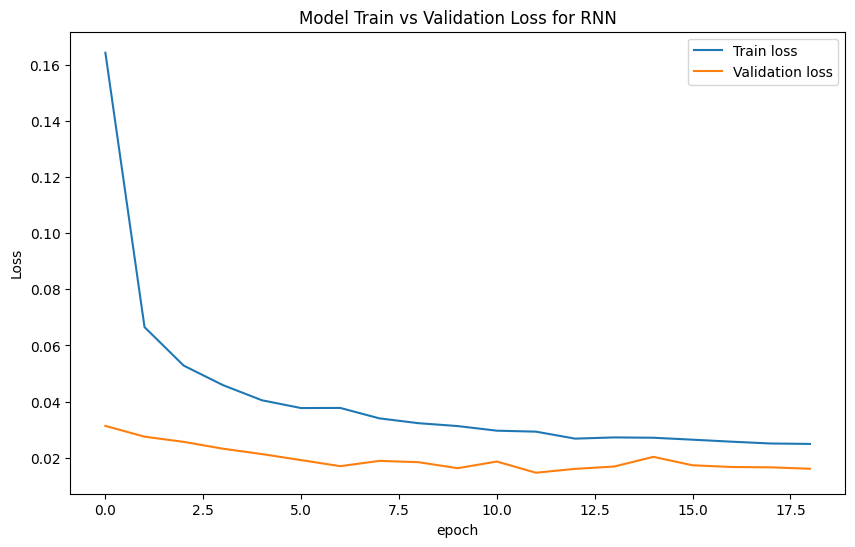

In [101]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.show()

# Plot loss
plot_loss (history_lstm, 'LSTM')
plot_loss (history_gru, 'GRU')
plot_loss (history_conv1d, 'Conv1D')
plot_loss (history_rnn, 'RNN')

### Step 4: Evaluation and Visulization

In [33]:
# Note that we have to use scaler_y
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [103]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

def prediction_cnn(model):
    prediction = model.predict(X_test)
    prediction = prediction[:, -1, :]
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)
prediction_conv1d = prediction_cnn(model_conv1d)
prediction_rnn = prediction(model_rnn)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
20/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [104]:
# Create a DataFrame for the actual and predicted values
comparison_df = pd.DataFrame({
    'Actual': y_test.flatten(),  
    'LSTM_Prediction': prediction_lstm.flatten(),  
    'GRU_Prediction': prediction_gru.flatten(),
    'Conv1d_Prediction': prediction_conv1d.flatten(),  
    'RNN_Prediction': prediction_rnn.flatten() 
})

# Display the first 10 elements of the DataFrame
comparison_df.head(10)

,Actual,LSTM_Prediction,GRU_Prediction,Conv1d_Prediction,RNN_Prediction
0,255.4360,292.039795,335.945953,678.552063,376.906494
1,152.0640,9.127079,45.037743,432.418060,13.160985
2,175.7460,-17.293102,-116.156815,434.586700,-16.145103
3,203.3800,70.715790,86.294289,630.436646,-36.398857
4,189.4590,93.666504,90.555382,737.471619,156.857376
5,90.3086,83.779846,42.596031,815.567139,111.503128
6,0.0000,-16.250095,-84.295090,721.534607,172.031937
7,0.0000,-7.822163,-98.875771,683.065552,7.207161
8,0.0000,-48.551941,-13.579700,556.058228,121.293793
9,0.0000,-42.069889,-17.155886,362.290466,80.020653


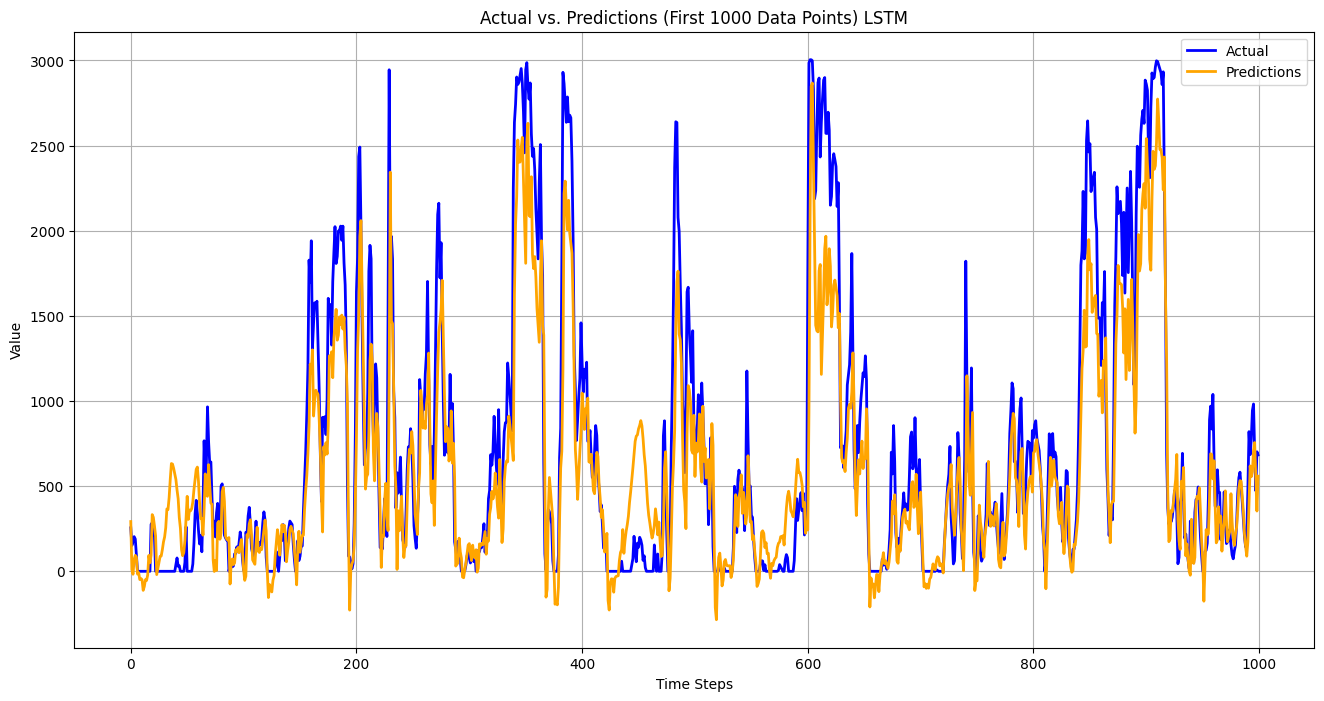

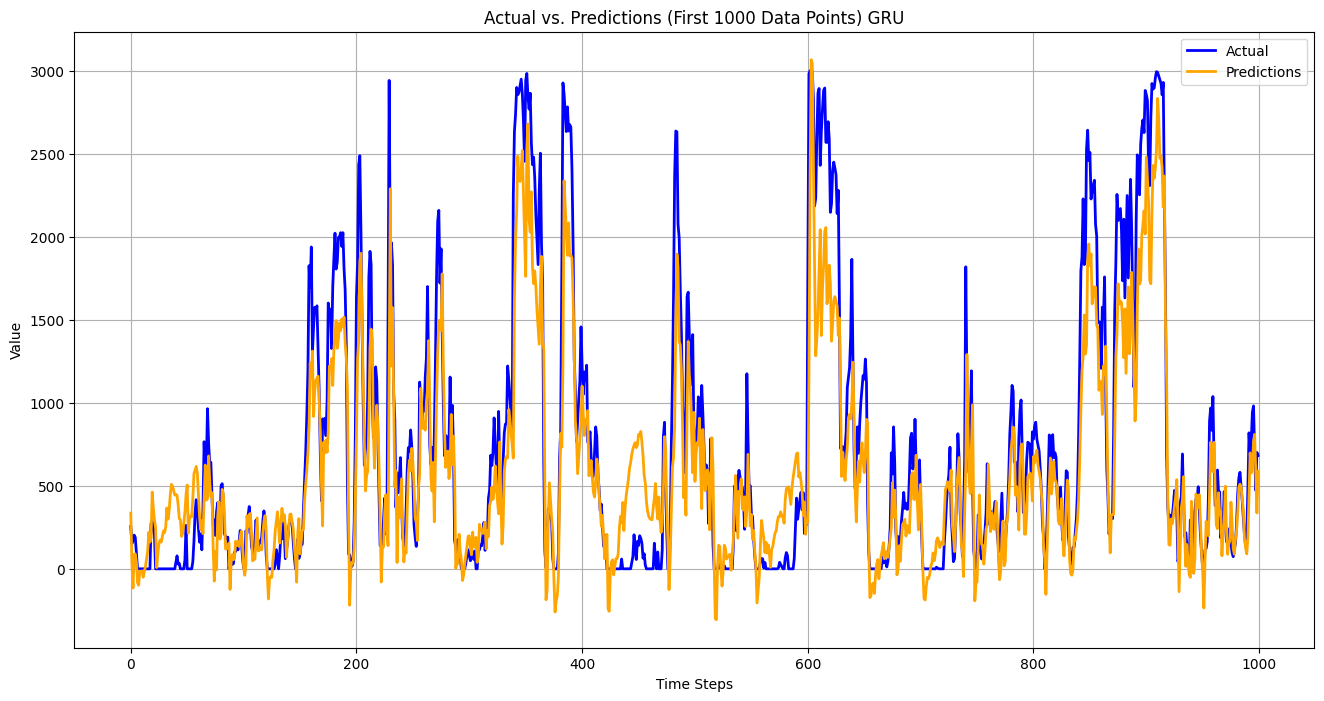

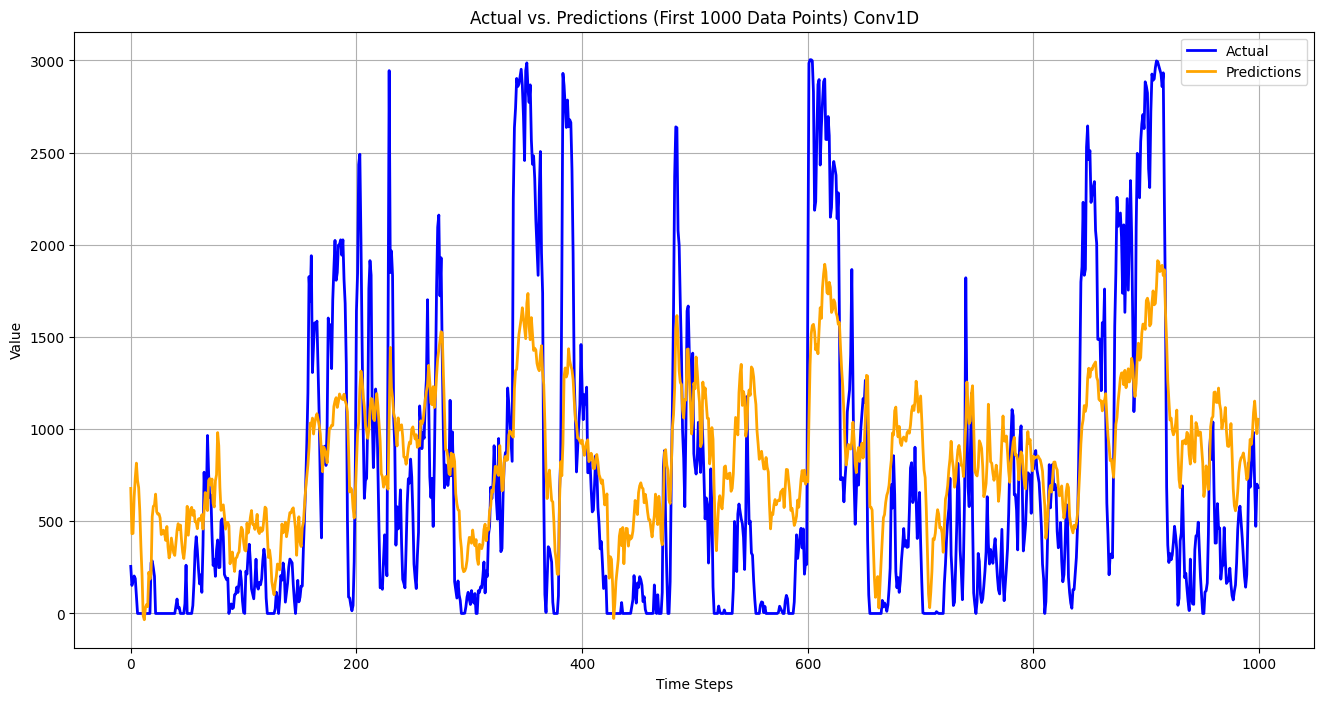

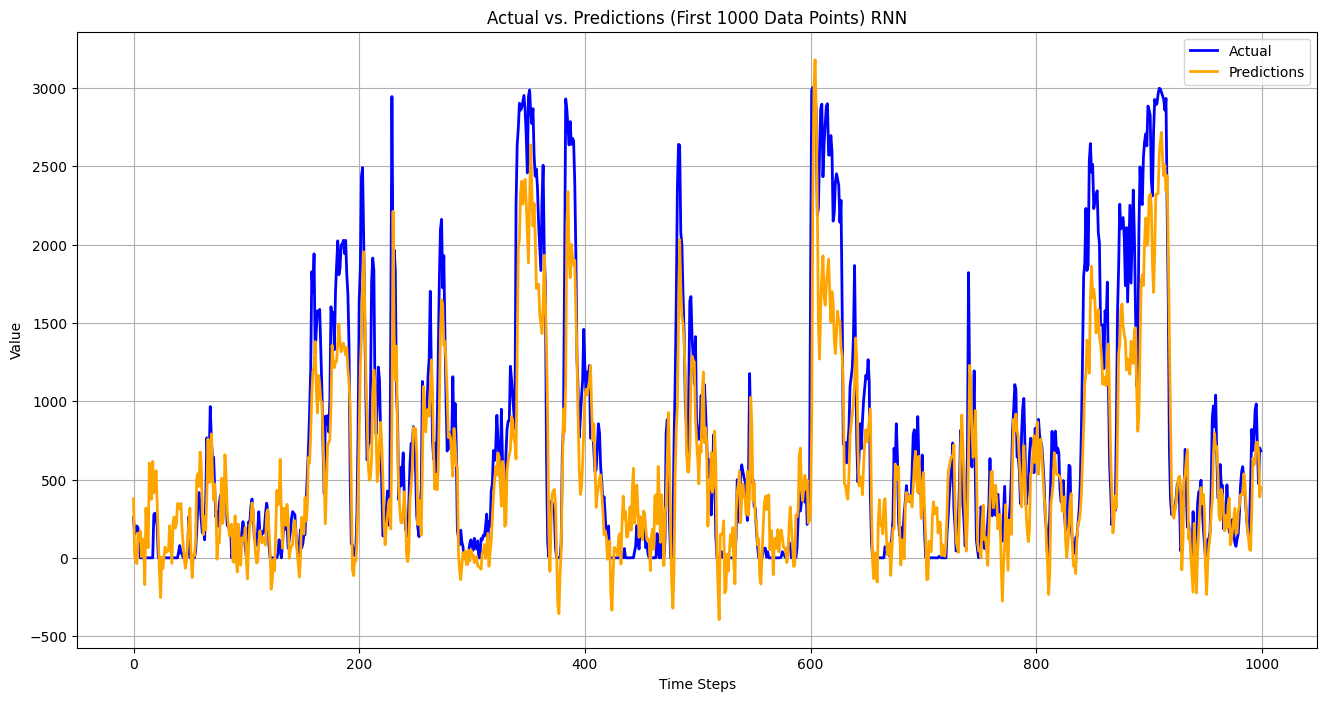

In [105]:
def plot_predictions_comparison(actual, prediction, model_name, num_points=1000):
    plt.figure(figsize=(16, 8))  # Increased figure size for better visibility

    # Select the first 1000 elements for plotting
    actual_plot = y_test[:num_points]
    prediction_plot = prediction[:num_points]

    # Create the plot
    plt.plot(actual_plot, label='Actual', color='blue', linewidth=2)
    plt.plot(prediction_plot, label='Predictions', color='orange', linewidth=2)

    plt.title('Actual vs. Predictions (First 1000 Data Points) ' + model_name)
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()



# Plot the first 1000 actual and predicted values
plot_predictions_comparison(y_test, prediction_lstm, 'LSTM')
plot_predictions_comparison(y_test, prediction_gru, 'GRU')
plot_predictions_comparison(y_test, prediction_conv1d, 'Conv1D')
plot_predictions_comparison(y_test, prediction_rnn, 'RNN')

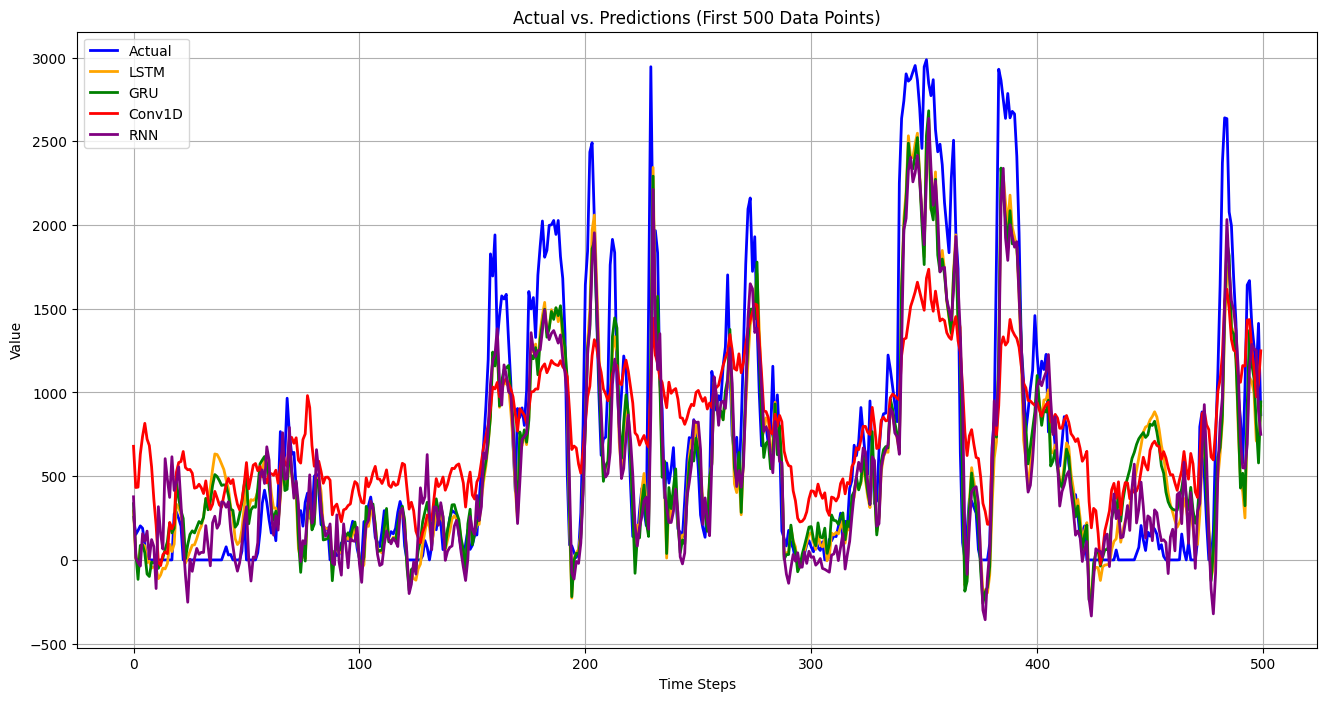

In [106]:
# plot all the models and the actual data for the first 500 data
plt.figure(figsize=(16, 8))
plt.plot(y_test[:500], label='Actual', color='blue', linewidth=2)
plt.plot(prediction_lstm[:500], label='LSTM', color='orange', linewidth=2)
plt.plot(prediction_gru[:500], label='GRU', color='green', linewidth=2)
plt.plot(prediction_conv1d[:500], label='Conv1D', color='red', linewidth=2)
plt.plot(prediction_rnn[:500], label='RNN', color='purple', linewidth=2)
plt.title('Actual vs. Predictions (First 500 Data Points)')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [107]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    mae = mean_absolute_error(actual, predictions)
    r2 = r2_score(actual, predictions)

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('R^2 Score: {:.4f}'.format(r2))
    print('')


evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_conv1d, y_test, 'Conv1D')
evaluate_prediction(prediction_rnn, y_test, 'RNN')

LSTM:
Mean Absolute Error: 282.7525
Root Mean Square Error: 417.3287
R^2 Score: 0.7664

GRU:
Mean Absolute Error: 287.2154
Root Mean Square Error: 411.2523
R^2 Score: 0.7732

Conv1D:
Mean Absolute Error: 500.4117
Root Mean Square Error: 601.3942
R^2 Score: 0.5149

RNN:
Mean Absolute Error: 304.6905
Root Mean Square Error: 434.6837
R^2 Score: 0.7466



### Gaussian Process Method

/home/abdulrahman.almansoo/.conda/envs/bigdataproject/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Mean Absolute Error: 128.7847
Root Mean Square Error: 369.9077
R^2 Score: 0.8149


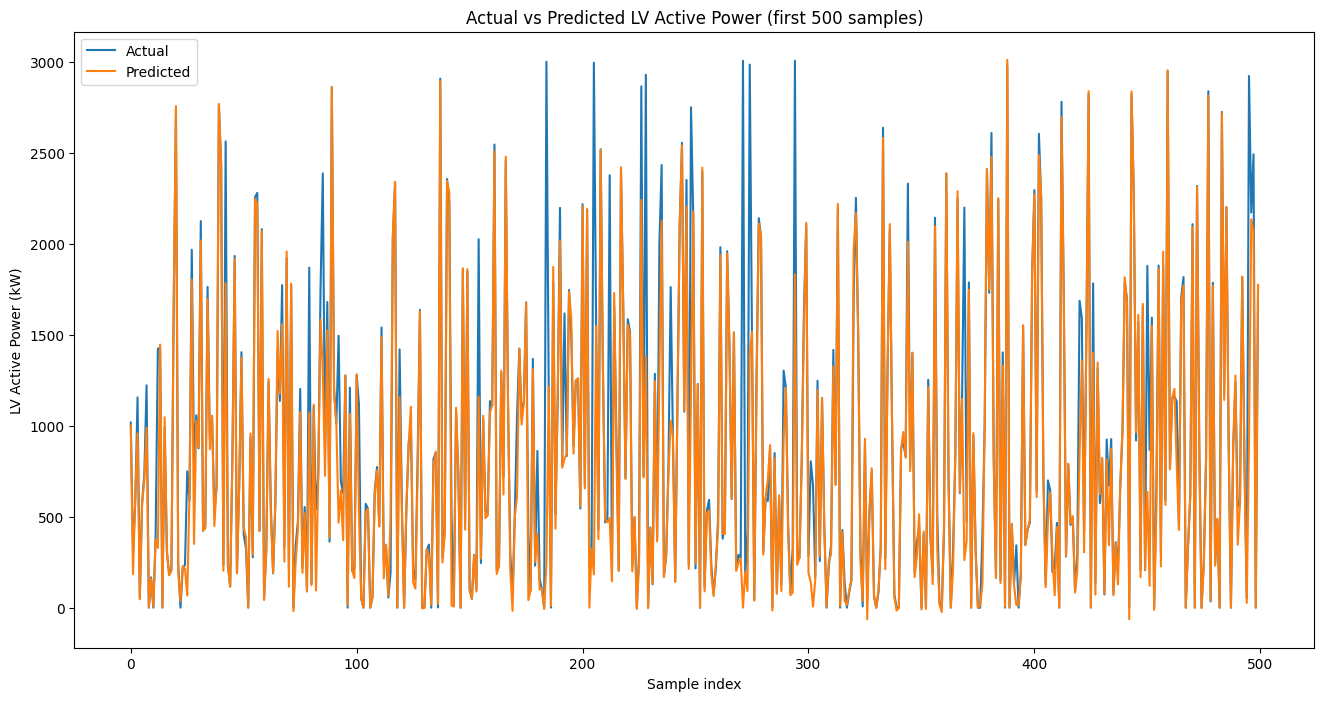

In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.gaussian_process.kernels import WhiteKernel

# Prepare data
X = data[['Wind speed | (m/s)', 'Pressure | (atm)', 'Wind direction | (deg)', 'Air_temperature (C)']].values
y = data['System power generated | (kW)'].values
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the kernel: a product of constant kernel and RBF kernel
kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))

# Create Gaussian process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1, alpha=1e-10)

# Fit the model
gp.fit(X_train, y_train)

# Make predictions
y_pred, y_std = gp.predict(X_test, return_std=True)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print performance metrics
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Root Mean Square Error: {rmse:.4f}')
print(f'R^2 Score: {r2:.4f}')

# Plot actual vs predicted for the first 500 points
plt.figure(figsize=(16, 8))
plt.plot(y_test[:500], label='Actual')
plt.plot(y_pred[:500], label='Predicted')
plt.fill_between(np.arange(500), y_pred[:500] - y_std[:500], y_pred[:500] + y_std[:500], alpha=0.2)
plt.title('Actual vs Predicted LV Active Power (first 500 samples)')
plt.xlabel('Sample index')
plt.ylabel('LV Active Power (kW)')
plt.legend()
plt.show()


### Linear Regression Method 

Root Mean Squared Error: 257.24864014891205
Mean Absolute Error: 215.35167566551243
R^2 Score: 0.9104886009487165


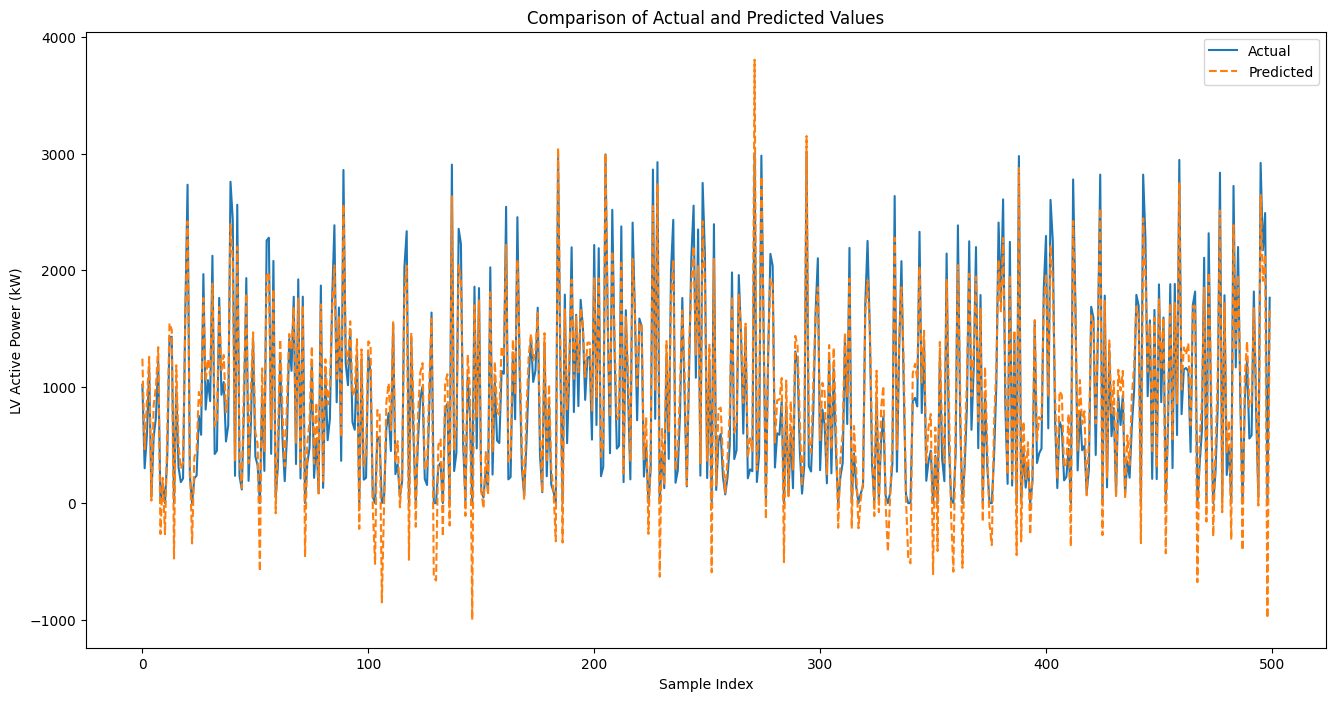

In [7]:
# Select features and target
X = data[['Wind speed | (m/s)', 'Pressure | (atm)', 'Wind direction | (deg)', 'Air_temperature (C)']]
y = data['System power generated | (kW)']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

# Plotting the first 500 actual vs predicted values
plt.figure(figsize=(16, 8))
plt.plot(y_test[:500].reset_index(drop=True), label='Actual')
plt.plot(y_pred[:500], label='Predicted', linestyle='--')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('LV Active Power (kW)')
plt.legend()
plt.show()
